## Photometry fitting of a star forming galaxy;

This notebook will demosntrate ...


In [1]:
# %matplotlib inline
%load_ext autoreload
%matplotlib widget
# %debug

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import ascii,fits
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.table import QTable
import astropy.units as u

from astropy import __version__ as asver
asver

'5.2.1'

In [3]:
# https://github.com/mtakahiro/gsf/tree/version1.4
import gsf
print(gsf.__version__)

from gsf.function import get_input,write_input
from gsf.gsf import run_gsf_template
from gsf.plot_sed import plot_sed, plot_corner_physparam_frame, plot_corner_physparam_summary
from gsf.plot_sfh import plot_sfh


Welcome to gsf version 1.7.7.dev23+gf95e336.d20230503
1.7.7.dev23+gf95e336.d20230503


/Users/morishita/miniconda3/envs/borg/lib/python3.9/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


## 1. Setup gsf

In [4]:
# If failed, make sure you have set GSF to the path of your GSF repository;
# export GSF=/your/Github/gsf-directory/
# where you can see `config` directory.
import os
GSF = os.environ['GSF']
GSF

'/Users/morishita/GitHub/gsf'

In [5]:
# Initial setup for gsf.

# Data directory;
DIR_DATA = './data/'
photom_file = 'JD1_photometry.txt'

# Auto load input dictionary;
inputs = get_input()

# Config directory;
inputs['CONFIG'] = os.path.join(GSF, 'config/')

# change Z;
# Flag;
fplt = 0
inputs['DIR_TEMP'] = './templates/'

# Output directory;
inputs['DIR_OUT'] = './output_photom/'

# If templates exit already, then let's save time.
# (But if you changed metallicity range or age pixels, fplt needs to be 0.)
if os.path.exists('%s/spec_all.asdf'%inputs['DIR_TEMP']):
    fplt = 1

    
# @ ID;
inputs['ID'] = 'JD1'


# @ Redshift
# Initial guess of redshift, or the true value if known. 
# We will later do redshift fit later, though.
zmcmin = 6.0
zmcmax = 15.0
zinitial = 9.793
inputs['ZMC'] = zinitial
inputs['ZMCMIN'] = zmcmin
inputs['ZMCMAX'] = zmcmax
# Redshift as a free parameter?
# If not (i.e. z fixed), set this to 0;
inputs['F_ZMC'] = 1


# @ Metallicity range
# in logZsun;
inputs['ZMIN'] = -2.0
inputs['ZMAX'] = 0.0
inputs['DELZ'] = 0.1
# You can fix metallicity;
#inputs['ZFIX'] = 0.0


# @ Age;
inputs['AGE'] = '0.001,0.003,0.01,0.03,0.1,0.3,1.0,3.0'
# You can fix age;
#inputs['AGEFIX'] = '0.1,0.3,1.0' # '0.1,0.3,0.5'


# @ Dust exinction;
inputs['AVMIN'] = 0.0 # Minimum Av (Dust Attenuation) in mag.
inputs['AVMAX'] = 1.0 # Maximum Av (Dust Attenuation) in mag.
# inputs['AVFIX'] = 0.0 #
# inputs['DUST_MODEL'] = 0


# @ Templates
inputs['NIMF'] = 1 # IMF
inputs['ADD_NEBULAE'] = 1 # Add nebular emission lines?
inputs['logUMIN'] = -3.0 # ionization parameter, in logU.
inputs['logUMAX'] = 0.0 # 
inputs['DELlogU'] = 0.5 # 
inputs['logUFIX'] = -2.5 # 
# BPASS template?
#inputs['BPASS'] = 1

# @ Data;
DIR_EXTR = DIR_DATA # Directory of extracted spectra;
inputs['CAT_BB'] = '%s/%s'%(DIR_DATA, photom_file)
inputs['MAGZP'] = 31.4 # Magnitude zeropoint for the input catalog and spectra;

# @ Filters;
# Each number corresponds to EAZY's filter ids. See also filter/filt_Sep20.lst
# These numbers need to be found in inputs['CAT_BB'] file.
# inputs['DIR_FILT'] = os.path.join(inputs['CONFIG'], 'filter/')
# inputs['FILTER'] = '309,310,311,308,1,4,6,202,203,204,205' # If not specified, gsf will guess this from CAT_BB.


# @ Morphology convolution; 
# Required for the NIRISS case;
# inputs['MORP'] = 'moffat'
# inputs['MORP_FILE'] = resolution_file 
# inputs['MORP'] = 'jwst-prism'

# @@ Not recommended when inputs['F_ZMC'] = 1, as it will take a huge amount of time;
# inputs['DIFF_CONV'] = 1 # Differential convolution of the template as a function of wavelength; 

# @ MCMC part;
inputs['FNELD'] = 1 #'differential_evolution' # Minimization method; 'nelder','powell'inputs['NCPU'] = 1 # For notebook, somehow multiprocessing causes error. So set to 1.
inputs['NMC'] = 1000 # NMC for the main SED fit
inputs['NMCZ'] = 30 # NMC for the redshift fit


# @ Visual inspection;
# Set to 0 (False), as Notebook cannot show actively iterating plot;
inputs['ZVIS'] = 0


# @ Emission line masking;
# If you want to mask emission lines, put RF wavelength, in AA;
#LW = [3727, 4341, 4861, 4960, 5008, 6563, 6717, 6731] # in AA, rest.
#inputs['LINE'] = LW


In [6]:
inputs, fplt

({'ID': 'JD1',
  'PA': '00',
  'ZMC': 9.793,
  'CZ0': 1.0,
  'CZ1': 1.0,
  'BPASS': 0,
  'DIR_OUT': './output_photom/',
  'DIR_TEMP': './templates/',
  'DIR_FILT': './filter/',
  'NIMF': 1,
  'NMC': 1000,
  'NWALK': 50,
  'NMCZ': 30,
  'NWALKZ': 20,
  'ZEVOL': 0,
  'ZVIS': 0,
  'FNELD': 1,
  'MC_SAMP': 'EMCEE',
  'CONFIG': '/Users/morishita/GitHub/gsf/config/',
  'ZMCMIN': 6.0,
  'ZMCMAX': 15.0,
  'F_ZMC': 1,
  'ZMIN': -2.0,
  'ZMAX': 0.0,
  'DELZ': 0.1,
  'AGE': '0.001,0.003,0.01,0.03,0.1,0.3,1.0,3.0',
  'AVMIN': 0.0,
  'AVMAX': 1.0,
  'ADD_NEBULAE': 1,
  'logUMIN': -3.0,
  'logUMAX': 0.0,
  'DELlogU': 0.5,
  'logUFIX': -2.5,
  'CAT_BB': './data//JD1_photometry.txt',
  'MAGZP': 31.4},
 1)

In [7]:
# Then, run template generate function;
mb = run_gsf_template(inputs, fplt=fplt)
fplt = 1

Log level set to INFO and output to logs
2023-05-02 21:08:51 | INFO     | gsf.fitting.gsf | init class | (fitting.py:96)
2023-05-02 21:08:51 | INFO     | gsf.fitting.gsf | Fitting target: JD1 | (fitting.py:161)




Checking the template library...
Speficied - Template
2023-05-02 21:08:52 | INFO     | gsf.fitting.gsf | Filters in the input catalog are: 205,204,203,202,239,364,365,366,375,376,377 | (maketmp_filt.py:478)
2023-05-02 21:08:52 | INFO     | gsf.fitting.gsf | No FIR is implemented. | (maketmp_filt.py:500)
2023-05-02 21:08:52 | INFO     | gsf.fitting.gsf | Making templates at z=9.7930 | (maketmp_filt.py:502)
2023-05-02 21:08:52 | INFO     | gsf.fitting.gsf | No spec file is provided. | (maketmp_filt.py:570)
2023-05-02 21:08:52 | INFO     | gsf.fitting.gsf | Done making templates at z=9.7930 | (maketmp_filt.py:1285)


In [8]:
# You can save the configuration as an ascii file and then run as;
# python run_gsf.py gsf.input 1 --id JD1 --z 9.8
write_input(inputs, file_out='gsf.input')


True

## 2. Initial fit at the input redshift

In [9]:
# Do a quick fit at z = z_guess;
mb.zprev = mb.zgal
#f_add = mb.add_param(mb.fit_params, sigz=mb.sigz, zmin=mb.zmin, zmax=mb.zmax)
out, chidef, Zbest, xm_tmp, fm_tmp = mb.quick_fit(f_get_templates=True)
out

#########
Quick fit
#########

#################
Preparing library
#################

Reading data with Cz0=1.00, Cz1=1.00, Cz2=1.00, zgal=9.79
##################
Setting parameters
##################

2023-05-02 21:08:54 | WARNING  | gsf.fitting.gsf | At this redshift, A6 is beyond the age of universe and not being used. | (fitting.py:1362)
2023-05-02 21:08:54 | WARNING  | gsf.fitting.gsf | At this redshift, A7 is beyond the age of universe and not being used. | (fitting.py:1362)


2023-05-02 21:08:55,264 - stpipe - WARNING - /Users/morishita/miniconda3/envs/borg/lib/python3.9/site-packages/lmfit/minimizer.py:847: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])

2023-05-02 21:08:55,265 - stpipe - WARNING - /Users/morishita/miniconda3/envs/borg/lib/python3.9/site-packages/lmfit/minimizer.py:854: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))

2023-05-02 21:08:55,414 - stpipe - WARNING - /Users/morishita/miniconda3/envs/borg/lib/python3.9/site-packages/lmfit/minimizer.py:854: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))

2023-05-02 21:08:55,415 - stpipe - WARNING - /Users/morishita/miniconda3/envs/borg/lib/python3.9/site-packages/lmfit/minimizer.py:847: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])

2023-05-02 21:08:55,885 - stpipe -

############################
Start MCMC for redshift fit
############################


100%|██████████████████████████████████████████| 30/30 [00:00<00:00, 325.93it/s]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [3.29206845 3.11025906 3.20361516 3.06508512]



Recommended redshift, Cz0, Cz1, and Cz2, 9.69477 0.99967 0.99828 1.00071, with chi2/nu=1.902




##############################################################
Input redshift is 98.997 per cent agreement.
Error is 3.137 per cent.
Input Cz0 is 99.967 per cent agreement.
Error is 1.179 per cent.
Input Cz1 is 99.828 per cent agreement.
Error is 5.672 per cent.
Input Cz2 is 99.929 per cent agreement.
Error is 2.815 per cent.
##############################################################



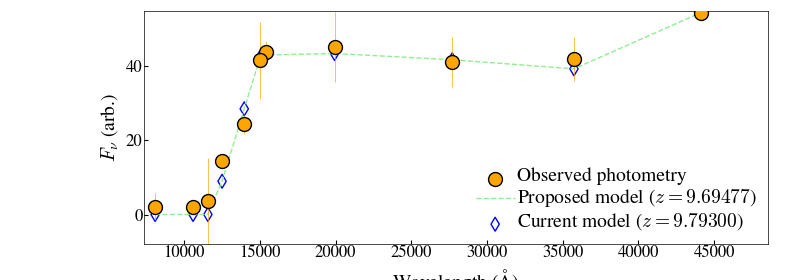

In [10]:
# Fit redshift with the proposed model;
# zmin and zmax will be set to zmcmin and zmcmax;

# @@@ Make sure that your data do not include ill defined values (e.g., error=1e10);
# Replace such values with np.nan
fig_zfit = mb.fit_redshift(xm_tmp, fm_tmp, include_photometry=True, return_figure=True)


## 3. Now, let's improve the fit by finding the true redshift;
@@@ The following part can be skipped; Then, go to 4.

### 3.1 Prepare Fitting Spectral Template from the library generated above;

In [11]:
dict_data = mb.read_data(mb.Cz0, mb.Cz1, mb.Cz2, mb.zgal)

# Here, we use 5 templates for find redshift;
ages = [0.01,0.03,0.1,0.3,1.0]
ntmp = len(ages)

for nn in range(ntmp):
    # For simplicity, no dust attenuation (Av=0), Z fixed to solar (Z=0).
    Amp = 1.0
    Av = 0
    Z = 0.0
    iix = np.where(ages[nn]==mb.age)
    flux_all, wave_all = mb.fnc.get_template_single(Amp, Av, iix, Z, mb.zgal, mb.lib_all)
    
    con_tmp = (1000 < wave_all / (1.+mb.zgal)) & (wave_all / (1.+mb.zgal) < 60000)

    # Don't forget to blueshift the template.
    xm_tmp = wave_all[con_tmp] / (1.+mb.zgal)
    fm_tmp = flux_all[con_tmp]

    if nn == 0:
        fm_tmps = np.zeros((ntmp,len(xm_tmp)),'float')

    fm_tmps[nn,:] = fm_tmp[:]
    

Reading data with Cz0=1.00, Cz1=1.00, Cz2=1.00, zgal=9.79


### 3.2 Then, run redshift fitting; 

2023-05-02 21:09:25,135 - stpipe - WARNING - /Users/morishita/miniconda3/envs/borg/lib/python3.9/site-packages/lmfit/minimizer.py:854: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))

2023-05-02 21:09:25,136 - stpipe - WARNING - /Users/morishita/miniconda3/envs/borg/lib/python3.9/site-packages/lmfit/minimizer.py:847: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])

2023-05-02 21:09:26,247 - stpipe - WARNING - /Users/morishita/miniconda3/envs/borg/lib/python3.9/site-packages/lmfit/minimizer.py:854: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))

2023-05-02 21:09:26,248 - stpipe - WARNING - /Users/morishita/miniconda3/envs/borg/lib/python3.9/site-packages/lmfit/minimizer.py:847: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])

2023-05-02 21:09:26,378 - stpipe -

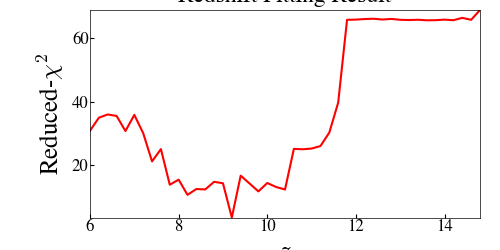

In [12]:
# dict : dictionary that includes a lot of things, including data.
# zliml, zlimu : Redshift search range, lower and upper limits.

# This should not be too small, if z-distribution is used as prior.
delzz = 0.2
zspace, chi2s = mb.search_redshift(dict_data, xm_tmp, fm_tmps, zliml=zmcmin, zlimu=zmcmax, delzz=delzz, include_photometry=True)


In [18]:
# Get z at the chi2 minimum;
# This is for the next step
izfit = np.argmin(chi2s[:,1])
zfit = zspace[izfit]
print('zfit at the minimum chi2 is: %.2f'%(zfit))

# And let's take reasonable z range;
zmcmin = 8.0
zmcmax = 11.0


zfit at the minimum chi2 is: 9.20


In [14]:
if False:
    # Use this chi2 as a redshift prior
    # for another redshift below (`fit_redshift`).
    prior = {}
    prior['z'] = zspace
    prior['chi2'] = chi2s[:,1]
else:
    # For now, prior is not functional;
    prior = None


In [15]:
# Or you can provide arbitrary prior;
# e.g., Users can provide phot-z prob by EAZY too.
if False:
    # Or define a new prior:
    zspace_tmp = np.arange(0,13,0.01)
    chi2s_tmp = zspace_tmp * 0 + 99
    con_tmp = (zspace_tmp>1.8) & (zspace_tmp<2.1)
    chi2s_tmp[con_tmp] = 1.0

    prior = {}
    prior['z'] = zspace_tmp
    prior['chi2'] = chi2s_tmp
    

In [19]:
# Initiate parameters at the updated redshift;
inputs['ZMC'] = zfit

# nmc for zfit;
inputs['NMCZ'] = 30


In [20]:
# Generate templates at the new redshift;
mb = run_gsf_template(inputs, fplt=fplt)


Log level set to INFO and output to logs
2023-05-02 21:09:57 | INFO     | gsf.fitting.gsf | init class | (fitting.py:96)
2023-05-02 21:09:57 | INFO     | gsf.fitting.gsf | Fitting target: JD1 | (fitting.py:161)


Checking the template library...
Speficied - Template
2023-05-02 21:09:57 | INFO     | gsf.fitting.gsf | Filters in the input catalog are: 205,204,203,202,239,364,365,366,375,376,377 | (maketmp_filt.py:478)
2023-05-02 21:09:57 | INFO     | gsf.fitting.gsf | No FIR is implemented. | (maketmp_filt.py:500)
2023-05-02 21:09:57 | INFO     | gsf.fitting.gsf | Making templates at z=9.2000 | (maketmp_filt.py:502)
2023-05-02 21:09:57 | INFO     | gsf.fitting.gsf | No spec file is provided. | (maketmp_filt.py:570)
2023-05-02 21:09:58 | INFO     | gsf.fitting.gsf | Done making templates at z=9.2000 | (maketmp_filt.py:1285)


### 3.3 Then, run minimizer before MCMC;

In [21]:
mb.zprev = mb.zgal
out, chidef, Zbest, _, _ = mb.quick_fit(f_get_templates=True)
out

#########
Quick fit
#########

#################
Preparing library
#################

Reading data with Cz0=1.00, Cz1=1.00, Cz2=1.00, zgal=9.20
##################
Setting parameters
##################

2023-05-02 21:10:02 | WARNING  | gsf.fitting.gsf | At this redshift, A6 is beyond the age of universe and not being used. | (fitting.py:1362)
2023-05-02 21:10:02 | WARNING  | gsf.fitting.gsf | At this redshift, A7 is beyond the age of universe and not being used. | (fitting.py:1362)


2023-05-02 21:10:03,200 - stpipe - WARNING - /Users/morishita/miniconda3/envs/borg/lib/python3.9/site-packages/lmfit/minimizer.py:854: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))

2023-05-02 21:10:03,200 - stpipe - WARNING - /Users/morishita/miniconda3/envs/borg/lib/python3.9/site-packages/lmfit/minimizer.py:847: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])

2023-05-02 21:10:03,596 - stpipe - WARNING - /Users/morishita/miniconda3/envs/borg/lib/python3.9/site-packages/lmfit/minimizer.py:854: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))

2023-05-02 21:10:03,596 - stpipe - WARNING - /Users/morishita/miniconda3/envs/borg/lib/python3.9/site-packages/lmfit/minimizer.py:847: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])

2023-05-02 21:10:04,564 - stpipe -

Reading data with Cz0=1.00, Cz1=1.00, Cz2=1.00, zgal=9.20


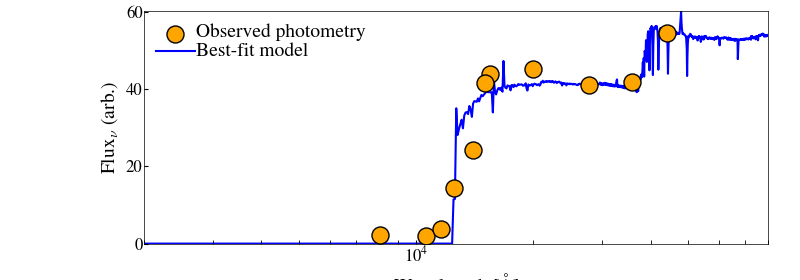

In [22]:
# Check the model derived by the minimizer; 
fig_fit_result = mb.plot_fit_result(out)

### 3.4 Now fit redshift in MCMC;
#### Difference of this part from the one above is that here we include a wider range of parameter space for the fitting model
#### Thus, having a narrowed range in redshift beforehand (i.e. one obtained above) will be helpful.

In [24]:
# Read the data, but with an updated scales (i.e. Cs);
dict_data = mb.read_data(mb.Cz0, mb.Cz1, mb.Cz2, mb.zgal)

# Narrow the redshift range
# for fine redshift sampling;
inputs['ZMCMIN'] = 9.0 #zmcmin
inputs['ZMCMAX'] = 10.5 #zmcmax

# Update inputs; 
inputs['NMCZ'] = 1000
inputs['NWALKZ'] = 300


Reading data with Cz0=1.00, Cz1=1.00, Cz2=1.00, zgal=9.20


### * Whenever you change the contents in the input dictionary (here, `input`), make sure to update pass it along;


In [25]:
mb.update_input(inputs)

2023-05-02 21:11:26 | INFO     | gsf.fitting.gsf | Fitting target: JD1 | (fitting.py:161)




True

############################
Start MCMC for redshift fit
############################


100%|██████████████████████████████████████| 1000/1000 [00:02<00:00, 468.31it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [51.31243058 57.55735436 62.77180588 51.91198834]



Recommended redshift, Cz0, Cz1, and Cz2, 9.24758 1.03631 0.98108 0.97891, with chi2/nu=2.894




##############################################################
Input redshift is 99.483 per cent agreement.
Error is 0.133 per cent.
Input Cz0 is 96.369 per cent agreement.
Error is 33.706 per cent.
Input Cz1 is 98.108 per cent agreement.
Error is 33.189 per cent.
Input Cz2 is 97.891 per cent agreement.
Error is 33.132 per cent.
##############################################################



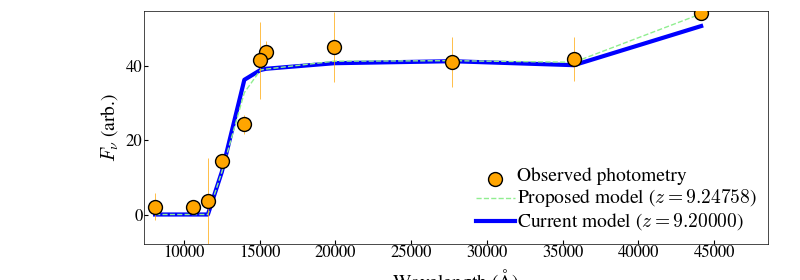

In [31]:
# Wanna try redshift fit even when BB photometry only?
include_photometry = True

# This works only when spectrum is provided.

# Get fitting templates by using the best-fit parameters, `out`, from above;
fm_tmp, xm_tmp = mb.fnc.get_template(out, f_val=True, lib_all=True)

# Then fit;
fig_fit_redshift = mb.fit_redshift(xm_tmp, fm_tmp, snlim=0, include_photometry=include_photometry, 
                                   priors=prior, delzz=0.01, # These two parameters are not in effect for now;
                                   return_figure=True)


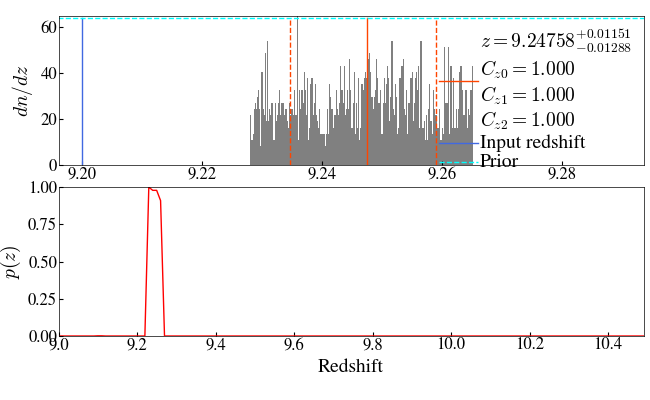

In [33]:
# @@@ Prior distribution may be invisible in the plot;
mb.get_zdist(f_interact=True)

In [34]:
# This is normalization;
# Should be ~1, as we have already normalized the spectra to BB fluxes.
print('Redshift 16/50/84th percentile range :',mb.z_cz)
print(mb.Czrec0)
print(mb.Czrec1)
print(mb.Czrec2)

Redshift 16/50/84th percentile range : [9.23469985 9.24757983 9.2590908 ]
1.0363064079951165
0.9810812964592093
0.9789145656454632


## 4. Now, run the whole SED fitting;
#### In this notebook, let's fix redshift to the one determined above

2023-05-02 21:14:50 | INFO     | gsf.fitting.gsf | Fitting target: JD1 | (fitting.py:161)


#################
Preparing library
#################

Reading data with Cz0=1.00, Cz1=1.00, Cz2=1.00, zgal=9.25
##################
Setting parameters
##################

2023-05-02 21:14:50 | WARNING  | gsf.fitting.gsf | At this redshift, A6 is beyond the age of universe and not being used. | (fitting.py:1362)
2023-05-02 21:14:50 | WARNING  | gsf.fitting.gsf | At this redshift, A7 is beyond the age of universe and not being used. | (fitting.py:1362)


2023-05-02 21:14:50,742 - stpipe - WARNING - /Users/morishita/miniconda3/envs/borg/lib/python3.9/site-packages/lmfit/minimizer.py:854: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))

2023-05-02 21:14:50,742 - stpipe - WARNING - /Users/morishita/miniconda3/envs/borg/lib/python3.9/site-packages/lmfit/minimizer.py:847: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])



########################
### Fitting Function ###
########################



###############################
Input redshift is adopted.
Starting long journey in MCMC.
###############################




Minimizer Defined

########################
### Starting sampling ##
########################

2023-05-02 21:14:50 | INFO     | gsf.fitting.gsf | sampling with EMCEE | (fitting.py:1772)


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 187.92it/s]



Running dummy sampler. Disregard message from here;



100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 122.52it/s]

The chain is shorter than 50 times the integrated autocorrelation time for 9 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 0;
tau: [1.14538572 1.14758501 1.10699494 1.08926331 1.0841321  1.03056402
 1.00450212 1.02360344 1.04773699]

to here.

###############################
### MCMC part took 5.8 sec ###
###############################
 => Saving data to cpklfile ./output_photom/chain_JD1_corner.cpkl


##########################
### Writing parameters ###
##########################


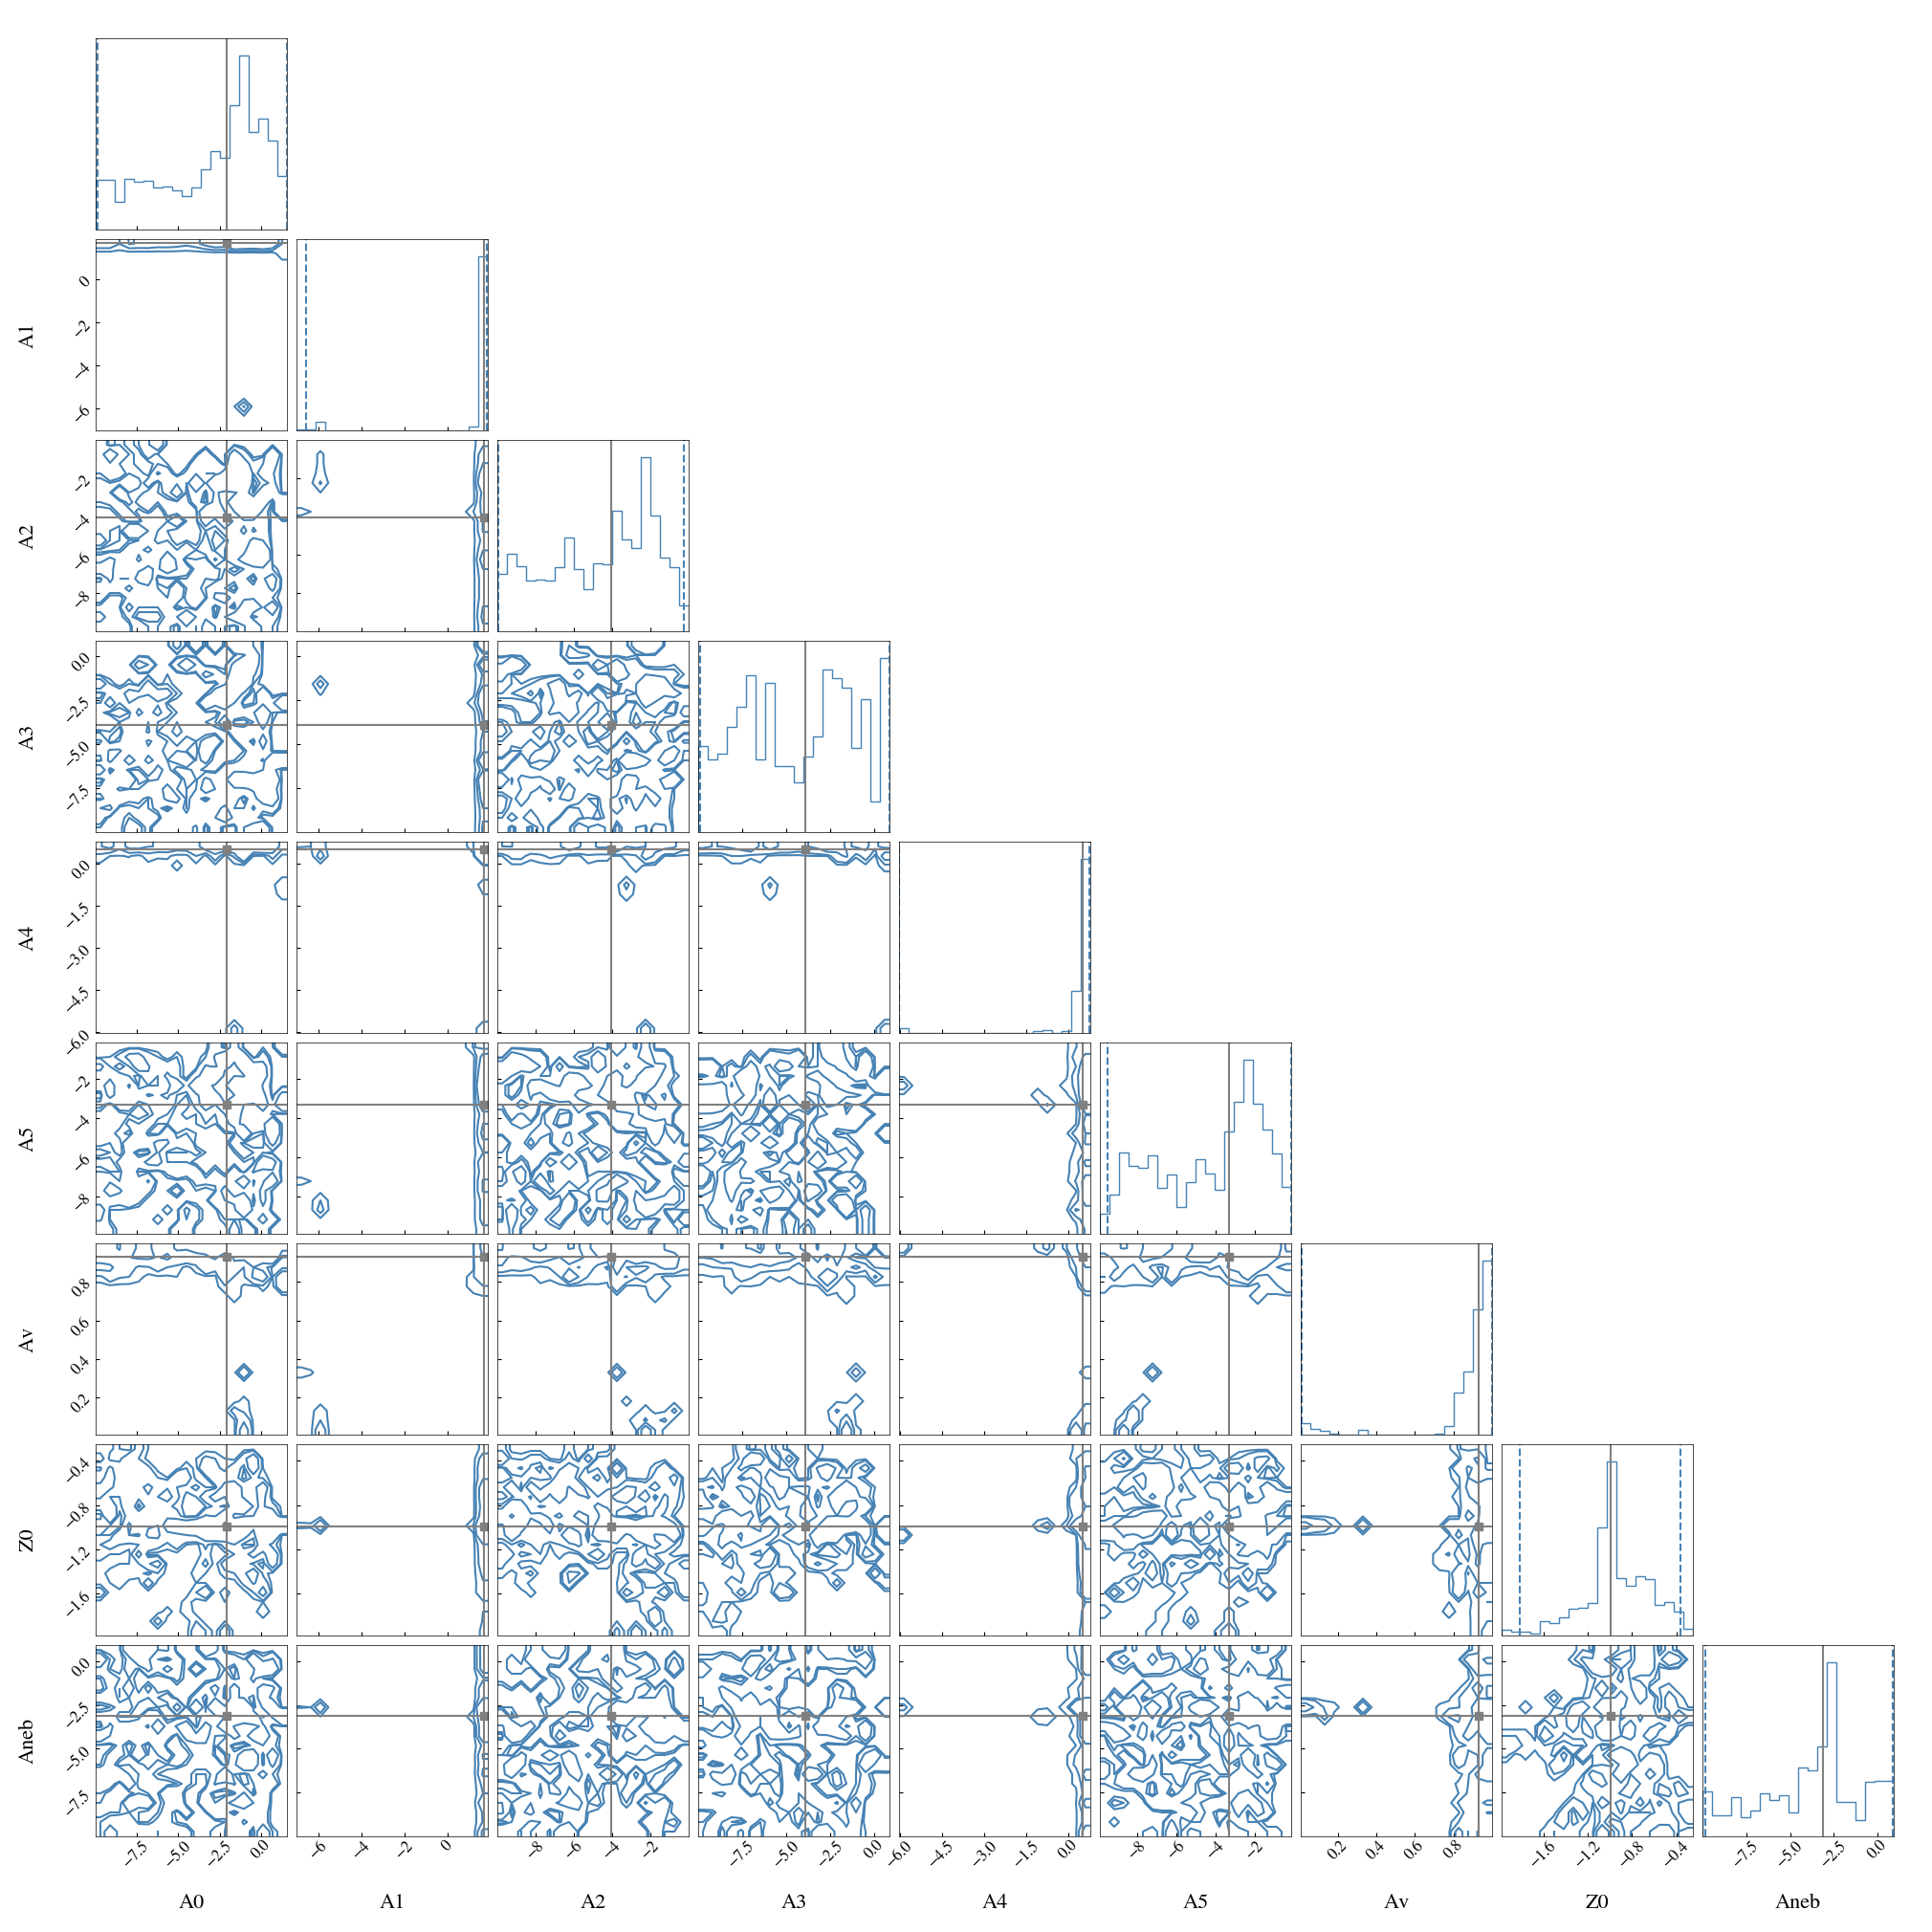

In [35]:
# No interactive fit;
inputs['ZVIS'] = 0
inputs['NMC'] = 1000

# Now redshift is determined above, let's fix z to it;
inputs['F_ZMC'] = 0
inputs['ZMC'] = mb.z_cz[1]
# Or free parameter;
# inputs['F_ZMC'] = 1

# If you like z as a free parameter;
# inputs['F_ZMC'] = 1
# inputs['ZMCMIN'] = mb.z_cz[1] - 0.2
# inputs['ZMCMAX'] = mb.z_cz[1] + 0.2

# Update inputs; 
mb.update_input(inputs)

# Since already z-fit done, we can skip z-fit;
skip_fitz = True

# Main;
flag_suc = mb.main(cornerplot=True, specplot=1, sigz=1.0, ezmin=0.01, ferr=0, f_move=False, skip_fitz=skip_fitz, out=out)


## 5. Visualize results


### Running plot_sfh ###


$$$ =================== $$$
$$$  gsf error message  $$$
2023-05-02 21:15:28.686777
$$$ =================== $$$

cpkl will be deprecated from gsf. Rerun your fit with the latest version, so your sampler will be saved in asdf.




2023-05-02 21:15:28,859 - stpipe - WARNING - /Users/morishita/GitHub/gsf/gsf/plot_sfh.py:342: RuntimeWarning: divide by zero encountered in log10
  SF[aa, mm] = AAtmp[aa] + np.log10(mslist[aa] / delT[aa] / f_m_sur) + Arand # / ml

2023-05-02 21:15:28,859 - stpipe - WARNING - /Users/morishita/GitHub/gsf/gsf/plot_sfh.py:349: RuntimeWarning: invalid value encountered in double_scalars
  SFR_SED[mm] += 10**SF[aa, mm] * delT[aa]



2023-05-02 21:15:33,546 - stpipe - WARNING - /Users/morishita/miniconda3/envs/borg/lib/python3.9/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)



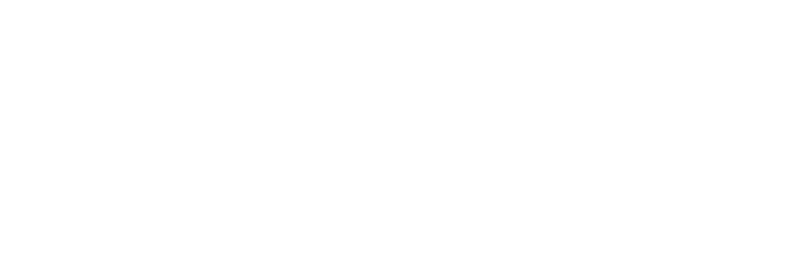

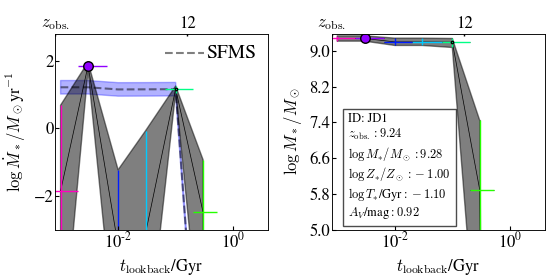

In [36]:
# Plot SFH;
f_symbol = True
skip_zhist = True
tau_lim = 0.01
tset_SFR_SED = 10
mmax = 300

# Plot Starforming Main Sequence from Speagle+14?
f_SFMS = True

dict_sfh, fig_sfh = plot_sfh(mb, fil_path=mb.DIR_FILT, mmax=mmax,
         dust_model=mb.dust_model, DIR_TMP=mb.DIR_TMP, f_silence=True, 
         f_SFMS=f_SFMS, f_symbol=f_symbol, skip_zhist=skip_zhist, tau_lim=tau_lim, 
         tset_SFR_SED=tset_SFR_SED, return_figure=True)


### The returned dictionary carries most of the infomation about SFH;

In [37]:
dict_sfh

{'id': 'JD1',
 'redshift': '9.244',
 'nimf': '1',
 'version_gsf': '1.7.7.dev23+gf95e336.d20230503',
 'sfh': {'time': <Quantity [1.e-03, 3.e-03, 1.e-02, 3.e-02, 1.e-01, 3.e-01, 1.e+00, 3.e+00] Gyr>,
  'time_l': <Quantity [0.    , 0.002 , 0.0065, 0.02  , 0.065 , 0.2   , 0.65  , 2.    ] Gyr>,
  'time_u': <Quantity [2.00e-03, 4.00e-03, 1.35e-02, 4.00e-02, 1.35e-01, 4.00e-01,
             1.35e+00, 4.00e+00] Gyr>,
  'SFR16': <Quantity [7.61907272e-08, 5.12363869e+01, 7.26460097e-08, 1.12147754e-07,
             1.13470873e+01, 9.83601394e-08,            nan,            nan] solMass / yr>,
  'SFR50': <Quantity [1.37463878e-02, 7.10415992e+01, 3.34128254e-04, 7.76165468e-04,
             1.46283658e+01, 3.22327045e-03,            nan,            nan] solMass / yr>,
  'SFR84': <Quantity [4.80274295e+00, 8.96522522e+01, 5.88279573e-02, 8.42933400e-01,
             1.77537838e+01, 1.16674422e-01,            nan,            nan] solMass / yr>,
  'Mstel16': <Quantity [1.63799016e+09, 1.63799015e+0


### Running plot_sed ###

Reading data with Cz0=1.00, Cz1=1.00, Cz2=1.00, zgal=9.24

$$$ =================== $$$
$$$  gsf error message  $$$
2023-05-02 21:17:13.432886
$$$ =================== $$$

cpkl will be deprecated from gsf. Rerun your fit with the latest version, so your sampler will be saved in asdf.




2023-05-02 21:17:20,128 - stpipe - WARNING - /Users/morishita/GitHub/gsf/gsf/function.py:78: RuntimeWarning: divide by zero encountered in log10
  fit_results = np.polyfit(np.log10(lm/(1.+zbes))[con_uv], np.log10(flam)[con_uv], 1) #, w=flam[con_uv])

2023-05-02 21:17:20,141 - stpipe - WARNING - /Users/morishita/miniconda3/envs/borg/lib/python3.9/site-packages/astropy/units/format/utils.py:220: UnitsWarning: The unit 'Angstrom' has been deprecated in the VOUnit standard. Suggested: 0.1nm.
  warnings.warn(message, UnitsWarning)

2023-05-02 21:17:20,177 - stpipe - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


f_fancyplot is False. f_fill is set to False.


No-of-detection    : 9
chi2               : 69.73
No-of-non-detection: 2
chi2 for non-det   : -10.32
No-of-params       : 9
Degrees-of-freedom : 2
Final chi2/nu      : 29.70


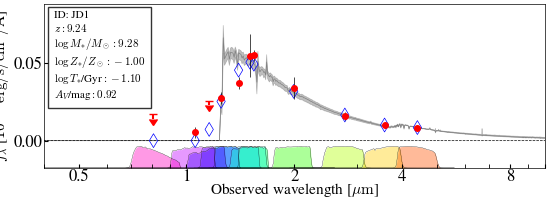

In [38]:
# Plot SED;
dict_sed, fig_sed = plot_sed(mb, fil_path=mb.DIR_FILT,
         figpdf=False, save_sed=True, mmax=300,
         f_fill=True, dust_model=mb.dust_model, DIR_TMP=mb.DIR_TMP, f_label=True,
         return_figure=True)


In [39]:
dict_sed

{'id': 'JD1',
 'redshift': '9.244',
 'isochrone': '',
 'library': '',
 'nimf': '',
 'scale': 1e-19,
 'm0set': 31.4,
 'version_gsf': '1.7.7.dev23+gf95e336.d20230503',
 'model': {'wave_bb': <Quantity [15425.94927881, 13980.87454642, 12492.71563232, 10576.41677034,
              8088.17628387, 11573.17492225, 15044.42667224, 19930.68708982,
             27689.66701004, 35751.48893141, 44154.31225018] Angstrom>,
  'fnu_bb_16': <Quantity [1.14450763e-06, 8.61859957e-07, 3.81417604e-07, 5.71195807e-11,
             1.64959137e-51, 8.93916456e-08, 1.11794559e-06, 1.23833607e-06,
             1.25056032e-06, 1.29204812e-06, 1.70004901e-06] uJy>,
  'fnu_bb_50': <Quantity [1.24041017e-06, 9.39240899e-07, 4.17838183e-07, 6.22574023e-11,
             1.91620011e-51, 1.02738368e-07, 1.20987593e-06, 1.33439775e-06,
             1.34217018e-06, 1.36513280e-06, 1.74072354e-06] uJy>,
  'fnu_bb_84': <Quantity [1.30743323e-06, 9.97614366e-07, 4.47758647e-07, 6.61331977e-11,
             2.19886407e-51, 1

Total stellar mass is 1.82e+09
Reading data with Cz0=1.00, Cz1=1.00, Cz2=1.00, zgal=9.25

$$$ =================== $$$
$$$  gsf error message  $$$
2023-05-02 21:17:20.744729
$$$ =================== $$$

cpkl will be deprecated from gsf. Rerun your fit with the latest version, so your sampler will be saved in asdf.




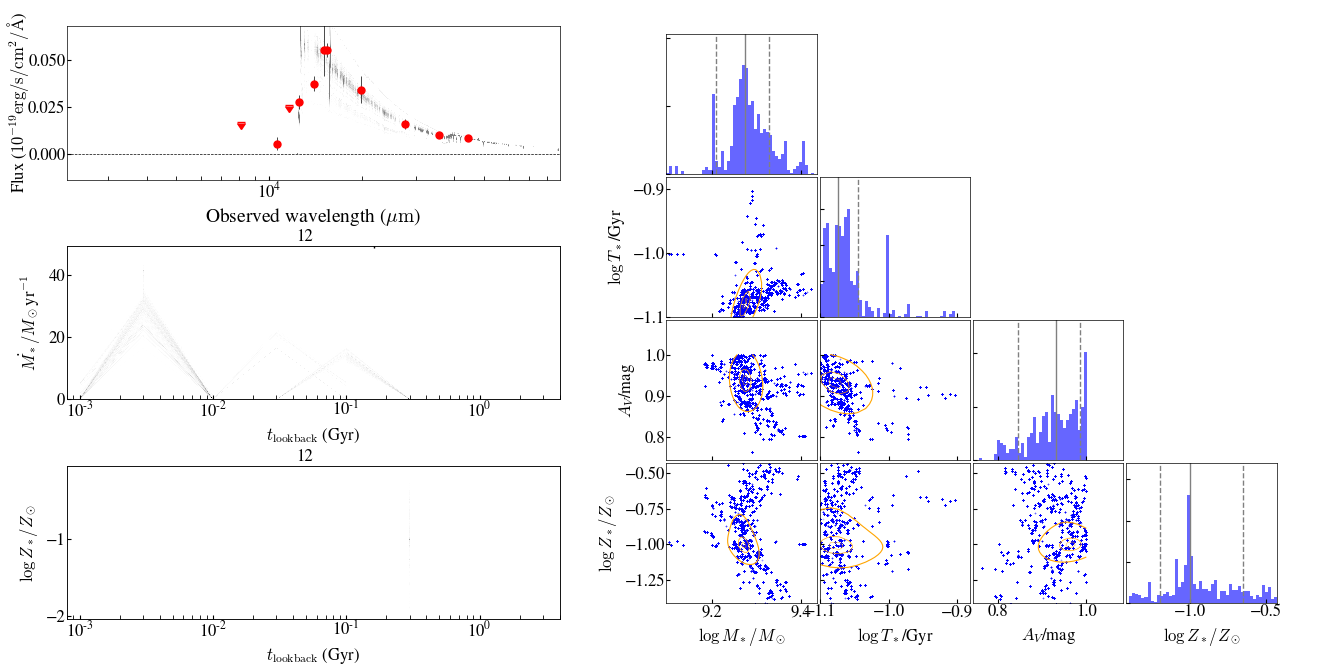

In [40]:
# Physical parameters;
fig_phys = plot_corner_physparam_summary(mb)